In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import tqdm
import os
import cv2
from pathlib import Path

In [3]:
train_test = Path(r'C:\Users\USER-PC\Documents\Data Science\data set\Surface crack detection')

In [4]:
from torchvision.datasets import ImageFolder


In [5]:
image_size = 32
stats = ((0.5, 0.45, 0.425), (0.35, 0.5, 0.253))

In [6]:
dataset = ImageFolder(train_test, transform = T.Compose([T.Resize(image_size),
                                                         T.CenterCrop(image_size),
                                                         T.ToTensor(),
                                                         T.Normalize(*stats)]))

In [7]:
dataset.classes

['Negative', 'Positive']

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.4426, 0.4314, 0.5210,  ..., 0.6891, 0.6331, 0.6218],
         [0.4986, 0.5322, 0.5322,  ..., 0.6667, 0.6218, 0.6555],
         [0.4650, 0.4762, 0.4762,  ..., 0.7227, 0.6891, 0.6443],
         ...,
         [0.3866, 0.3866, 0.3529,  ..., 0.5882, 0.5770, 0.5658],
         [0.3866, 0.3866, 0.3305,  ..., 0.5434, 0.5882, 0.5882],
         [0.4090, 0.3754, 0.3641,  ..., 0.5098, 0.5322, 0.5434]],

        [[0.3863, 0.3784, 0.4412,  ..., 0.5588, 0.5196, 0.5118],
         [0.4255, 0.4490, 0.4490,  ..., 0.5431, 0.5118, 0.5353],
         [0.4020, 0.4098, 0.4098,  ..., 0.5824, 0.5588, 0.5275],
         ...,
         [0.3471, 0.3471, 0.3392,  ..., 0.4804, 0.4725, 0.4725],
         [0.3392, 0.3392, 0.3157,  ..., 0.4490, 0.4804, 0.4804],
         [0.3549, 0.3314, 0.3392,  ..., 0.4255, 0.4412, 0.4490]],

        [[0.7847, 0.7692, 0.8932,  ..., 1.1257, 1.0482, 1.0172],
         [0.8622, 0.9087, 0.9087,  ..., 1.0947, 1.0327, 1.0637],
         [0.8157, 0.8312, 0.8312,  ..., 1.1567, 1.0947, 1.

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Negative (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


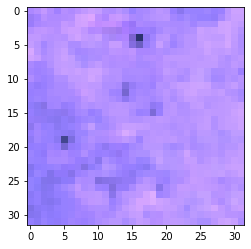

In [10]:
show_example(*dataset[3])

In [11]:
random_seed = 20
torch.manual_seed(random_seed)
batch_size = 200

In [12]:
len(dataset)

40000

In [13]:
val_size = 4000
#test_size = 

train_size = len(dataset) - val_size

train, val = random_split(dataset, [train_size, val_size])

In [14]:
len(train), len(val)

(36000, 4000)

In [15]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle= True, collate_fn=None, num_workers=4, pin_memory = True)
val_loader = DataLoader(val, batch_size=batch_size*2, num_workers=4, collate_fn=None, pin_memory=True)

In [16]:
def showbatch(data):
    for image, label in data:
        fig, ax = plt.subplots(figsize = (12, 6))
        plt.xticks([]); plt.yticks([])
        plt.imshow(make_grid(image, nrow=8).permute(1, 2, 0))
        break

C:\Users\USER-PC\anaconda3.8\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


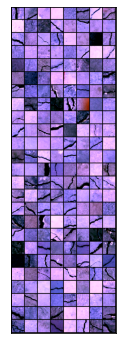

In [17]:
showbatch(train_loader)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        epoch_accuracies = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accuracies.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [20]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
torch.cuda.is_available()

False

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title("Loss Vs. No of epoochs")

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title("Accuracy Vs. No of epochs")

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [28]:
input_size = 3*32*32
hidden_size1 = 1024
hidden_size2 = 512 
hidden_size3 = 128
hidden_size4 = 32
hidden_size5 = 8
output_size = 2
batch_size = 200

In [29]:
class SurfaceDetectionModel(ImageClassificationBase):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.linear5 = nn.Linear(hidden_size4, output_size)
            
    def forward (self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [30]:
model = to_device(SurfaceDetectionModel(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size), 
                  device)

In [31]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6961950659751892, 'val_acc': 0.49424996972084045}]

In [ ]:
history += fit(7, 0.1, model, train_loader, val_loader)

Epoch[0], val_loss: 0.3835, val_acc: 0.8360
Epoch[1], val_loss: 0.4614, val_acc: 0.7850
Epoch[2], val_loss: 0.3176, val_acc: 0.8680
Epoch[3], val_loss: 0.5461, val_acc: 0.6973


In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = train[100]
plt.imshow(img.permute(1, 2, 0))
print("Label: ", dataset.classes[label], ", Predicted: ", predict_image(img, model))

In [ ]:
img, label = dataset[38000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], ", Predicted", predict_image(img, model))

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model))

In [ ]:
val_loader = DataLoader(val, batch_size*3, shuffle = True, num_workers = 3, collate_fn = None, pin_memory = True)
result = evaluate(model, val_loader)
result

An accuracy of 93.41% was achieved upon training.

# USING A CNN

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle= True, collate_fn=None, num_workers=4, pin_memory = True)
val_loader = DataLoader(val, batch_size=batch_size*2, num_workers=4, collate_fn=None, pin_memory=True)

In [ ]:
class SurfaceDetectionCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = SurfaceDetectionCNNModel()
model2

In [ ]:
evaluate(model2, val_loader)

In [ ]:
def predict_image(img, model2):
    xb = to_device(img.unsqueeze(0), device)
    yb = model2(xb)
    _, preds = torch.max(yb, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1

In [ ]:
history += fit(num_epochs, lr, model2, train_loader, val_loader, opt_func)
history

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
img, label = dataset[2000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
img, label = dataset[15000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
val_loader = DataLoader(val, batch_size*3, shuffle = True, num_workers = 3, collate_fn = None, pin_memory = True)
result = evaluate(model2, val_loader)
result

Comparing the Feedforward Neural Network with the Convolutional Neural Network shows that Feed forward architecture performed better than the convolutional neural network.